Thoughts on a longwire antenna. <br>
<hr>
28-Jan-23      CBL       Original 
<hr>
references: 
Inductance of a long wire: <br> 
https://www.electronics-notes.com/articles/basic_concepts/inductance/inductance-of-straight-wire-coils.php <br> 
https://physics.stackexchange.com/questions/11799/derivation-of-self-inductance-of-a-long-wire <br>
$ L = {\Phi \over{I}}$ <br>
<br>
Capacitance of a long wire over a conducting plane: <br> 
https://www.emisoftware.com/calculator/wire-over-ground-plane-capacitance/ <br> 
scipi.constants have all the physical constants in it. <br>
https://docs.scipy.org/doc/scipy/reference/constants.html <br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants   as konst

Solenoid calculation: <br>
$ L = {N^2 \mu_{0} A \over{l}}$ <br> 
if $R_2$ is wire radius and $R_1$ is the form radius then: <br> 
$A = \pi ({(R_1 + R_2)\over{2}})^2$

In [69]:
def SolenoidInductance(length, form_radius, wire_radius, NTurns):
    """
    @param length - length in m of coil (defines spacing)
    @param form_radius - in meters
    @param wire_radius - in meters
    @param NTurns - unitless
    
    reference: https://quickfield.com/advanced/long_solenoid_inductance.htm
    """
    Area = np.pi*np.power((2*form_radius+wire_radius)/2.0,2.0) 
    L = np.power(NTurns, 2.0) * konst.mu_0 * Area/length
    return L

In [91]:
def N_from_L(Inductance, length, form_radius, wire_radius):
    """
    @param Desired inductance
    @param length - length in m of coil (defines spacing)
    @param form_radius - in meters
    @param wire_radius - in meters
    returns NTurns - unitless
    
    reference: https://quickfield.com/advanced/long_solenoid_inductance.htm
    """
    Area = np.pi*np.power((2*form_radius+wire_radius)/2.0,2.0) 
    NTurns = np.sqrt(Inductance*length/Area/konst.mu_0)
    return NTurns

In [70]:
def Inductance(length, radius):
    """
    Compute low frequency inductance of a long wire in Heneries
    @param length - length of wire in m
    @param radius - radius of wire in m
    
    https://www.electronics-notes.com/articles/basic_concepts/inductance/inductance-of-straight-wire-coils.php
    """
    L_dc = 2.0*length*1.0e2*(np.log(2*length/radius)-0.75) * 1.0e-9
    
    return L_dc

Grover Calculation: <br> 
$ L_{wire} = 2l\{ ln \left[ ({2L \over{D}}) (1+\sqrt{1+({D \over{2L}})^2})\right] -  \sqrt{1+({D \over{2L}})^2} +{\mu \over{4}} +({D\over{2L}})\}$

In [71]:
def Inductance2(length, Diameter):
    """
    more accurate calculation based on grover
    @param length - length of wire in cm
    @param Diameter - of wire in cm
    
    https://www.allaboutcircuits.com/tools/wire-self-inductance-calculator/
    
    """
    D_2L    = Diameter/(2.0*length)           # D/2L appears often calculate it here
    sqrtval = np.sqrt(1.0+(D_2L*D_2L))        # sqrt (1+(D/2L)^2) also appears often
    L = 2.0 * length * (np.log((1.0+sqrtval)/D_2L) - sqrtval + konst.mu_0/4.0 + D_2L)
    return L*1.0e-9                           # scale to Henries

In [72]:
def InductanceOverGP(length, Diameter, height):
    """
    Still assuming the earth is a decent conductor. 
    https://www.allaboutcircuits.com/tools/wire-over-plane-inductance-calculator/
    @param length
    @param Diameter
    @param height
    """
    L = konst.mu_0 * length/(2.0*np.pi) * np.arccosh(height/Diameter) 
    return L

In [73]:
def Capacitance(length, height, radius):
    """
    determine the capacitance per length of a wire over a ground plane. This does not take
    into account the conductivity of the ground plane. 
    @param length - m 
    @param height - m height above ground plane
    """
    #e_0 =  8.854187812813e-12    # F/m
    C = 2.0 * np.pi * length * konst.epsilon_0/(np.arccosh(height/radius)) # in Farads
    
    return C

In [74]:
def Freq(L,C):
    return 1.0/(2.0*np.pi*np.sqrt(L*C))

In [75]:
# 
# AWG wire sizes: https://pbxbook.com/other/awgsizes.html
# 22 gauge wire
awg_22 = 0.64516e-3        # diameter in meters
r_22 = awg_22/2  # * 1.0e-3   # AWG radius in meters
Len = 50.0                 # Length of longwire meters
h = 2.0                    # height above the ground plane in meters
OnlineResult_L = 1.19e-4
Cwop = Capacitance( Len, h, r_22)
L = Inductance (Len, r_22)
print("Cap: ", Cwop)
print("L: ", L)
# convert from m to cm, input is in cm
print("L2: ", Inductance2(Len*100,awg_22*100))
print("F: ", 1.0/(2.0*np.pi*np.sqrt(L*Cwop)))
print("Z: ", np.sqrt(L/Cwop))
# something is not quite right. 
# having a resonant frequency of 850kHz seems odd.

Cap:  2.9511843289966395e-10
L:  0.0001189432957646333
L2:  0.00011644336342212189
F:  849477.6942447078
Z:  634.8510116564031


In [76]:
# lets do the inverse calculation
F0 = 849477.0 # Hz
Lambda = konst.c/F0
print ("Lambda: ", Lambda, " meters")
#
# For the given inductance, what capacitance would we get
#
C_calc = 1.0/(np.power(2.0*np.pi*F0, 2)*L)
print(" Requred Capacitance: ", C_calc)

Lambda:  352.91415541562634  meters
 Requred Capacitance:  2.9511891527763054e-10


In [77]:
# Lets try this for a 10m dipole. 
F10 = 28.0e6               # Hz
Lambda10 = konst.c/F10/2.  # dipole length
print("Dipole length: ", Lambda10, " meters")

Dipole length:  5.35343675  meters


In [78]:
# test wire over ground plane. 
# online results
wop_result = 0.0000943       # Henries
Lwop       = InductanceOverGP(0.05, awg_22, h)
print(" Results: ", Lwop)
# Off by 7% or so, 

 Results:  8.732306549774375e-08


In [79]:
#Recalculate based on this
RFreq = Freq(Lwop, Cwop)
print("New Freq: ", RFreq*1.0e-6)

New Freq:  31.351438828657283


This makes a hell of a lot more sense. <br>
I should look into what is the derivation of inductance and capacitance of wire over conductor such that I
can add in the conductivity. Take a look at Kraichman that has a lot of calculations in conductive media. Also
https://www.hindawi.com/journals/js/2016/2765812/

In [80]:
omega = 2*np.pi*RFreq
print("Zwop: ", np.sqrt(Lwop/Cwop))

Zwop:  17.201499954058033


Text(0, 0.5, 'Ohms')

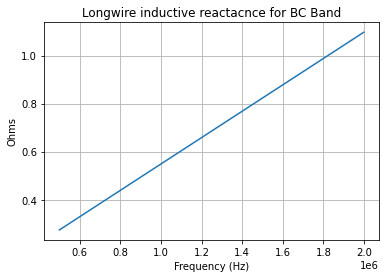

In [81]:
# Lets see how this behaves as a function of frequency
fsweep  = np.arange(500.0e3,2.0e6,1.0e3)
omega   = 2.0*np.pi*fsweep
XLsweep = omega*Lwop
XCsweep = 1.0/(omega*Cwop)
plt.plot(fsweep, XLsweep)
plt.grid()
plt.title("Longwire inductive reactacnce for BC Band")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Ohms")


Text(0, 0.5, 'Ohms')

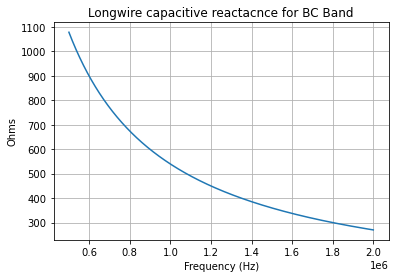

In [82]:
plt.plot(fsweep, XCsweep)
plt.grid()
plt.title("Longwire capacitive reactacnce for BC Band")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Ohms")


This is all for an endfed wire (Zepp). This changes pretty dramatically for a dipole due to boundry conditions. A 9:1 balun will bring this down some. 

Text(0, 0.5, 'Ohms')

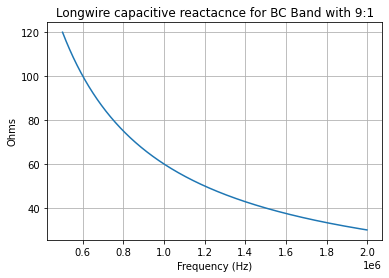

In [83]:
plt.plot(fsweep, XCsweep/9.0)
plt.grid()
plt.title("Longwire capacitive reactacnce for BC Band with 9:1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Ohms")


In [84]:
550/(2.0*np.pi*1.0e6)

8.753521870054244e-05

Text(0, 0.5, 'uH')

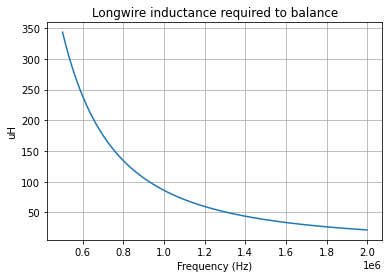

In [85]:
# L necessary to counterbalance
Lfix = XCsweep/omega
plt.plot(fsweep, Lfix*1.0e6)
plt.grid()
plt.title("Longwire inductance required to balance")
plt.xlabel("Frequency (Hz)")
plt.ylabel("uH")

In [90]:
# test solenoid
R_Form = 3.5/2.0 * 0.0254  # 3.5 inches converted to meters. 
L_Form = 3.0 * 0.0254
LForm  = SolenoidInductance(L_Form, R_Form, r_22, 50)
#
# Professor Coyle: https://www.crystalradio.net/professorcoyle/professorcoylecyl.shtml
# gets: 167uH
expected = 167e-6 * 1.43 # the 1.43 corrects for the wire diameter
print("result: ", LForm*1.0e6, " H ", expected/LForm)

result:  257.7711669547095  H  0.9264418624522074


In [92]:
# test case 2
L_test2 = SolenoidInductance(0.5, 0.03, 0.005, 100)
print("Test 2: ", L_test2)
# this is close. 
# Check Nturns
NT = N_from_L(L_test2, 0.5, 0.03, 0.005)
print (" NT: ", NT)

Test 2:  8.339815723460502e-05
 NT:  100.0


Text(0, 0.5, 'uH')

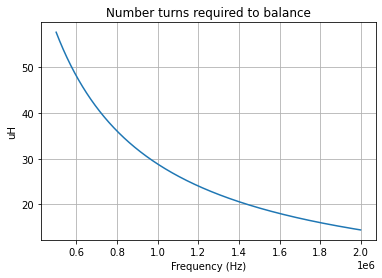

In [93]:
# L necessary to counterbalance, now in terms of N on a 3.5 inch form
Lfix = XCsweep/omega
Nturns = N_from_L(Lfix, L_Form, R_Form, r_22)
plt.plot(fsweep, Nturns)
plt.grid()
plt.title("Number turns required to balance")
plt.xlabel("Frequency (Hz)")
plt.ylabel("uH")